In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from node2vec import Node2Vec
import plotly.graph_objects as go
import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

In [3]:
def adding_to_graph(clauses):
    G = nx.Graph()
    for clause in clauses:
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))
    return G

def generate_node_embeddings(G):
    node2vec = Node2Vec(G, dimensions=64, walk_length=40, num_walks=40, workers=4)
    print("Generating node embeddings...")
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model

In [22]:
def operations(model, graph, num_clusters=3):
    node_ids = list(graph.nodes)
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings_2d)

    return node_ids, embeddings_2d, cluster_labels

In [4]:
def visualize_node_embeddings(model):
    node_ids = model.wv.index_to_key
    node_embeddings = [model.wv[str(node_id)] for node_id in node_ids]

    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(node_embeddings)

    plt.figure(figsize=(8, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    for i, txt in enumerate(node_ids):
        plt.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]), xytext=(5, 2), textcoords='offset points')
    plt.title('Node Embeddings Visualization (2D)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

In [25]:
def visualize_cluster_node_embeddings(model, graph, num_clusters=3, selected = None):
    node_ids, embeddings_2d, cluster_labels = operations(model, graph, num_clusters)

    plt.figure(figsize=(10, 8))
    for i in range(num_clusters):
        cluster_points = embeddings_2d[cluster_labels == i]
        if selected is None or i == selected-1:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i + 1}')

            if selected is None or i == selected-1:
                for j, txt in enumerate(node_ids):
                    if cluster_labels[j] == i:
                        plt.annotate(txt, (embeddings_2d[j, 0], embeddings_2d[j, 1]), xytext=(2, 2), textcoords='offset points', fontsize=7)

    plt.title(f'Node Embeddings Clustering (K-means, {num_clusters} clusters)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

In [30]:
def visualize_interactive(model, graph, num_clusters=3, selected = None):
    window_width = 1000
    window_height = 800
    node_ids, embeddings_2d, cluster_labels = operations(model, graph, num_clusters)

    df = pd.DataFrame({'X': embeddings_2d[:, 0], 'Y': embeddings_2d[:, 1], 'Node': node_ids, 'Cluster': cluster_labels})

    app = dash.Dash(__name__)

    app.layout = html.Div([
        dcc.Graph(id='scatter-plot'),
        dcc.Dropdown(
            id='cluster-dropdown',
            options=[{'label': f'Cluster {i}', 'value': i} for i in range(num_clusters)],
            value=None,
            placeholder="Select a cluster"
        )
    ])

    @app.callback(
        Output('scatter-plot', 'figure'),
        [Input('cluster-dropdown', 'value')]
    )
    def update_scatter_plot(selected_cluster):
        fig = go.Figure()

        for i in range(num_clusters):
            visible_points = [True if label == i else False for label in df['Cluster']]
            if selected_cluster is None or i == selected_cluster:
                fig.add_trace(go.Scatter(
                    x=df[visible_points]['X'],
                    y=df[visible_points]['Y'],
                    mode='markers+text',
                    marker=dict(size=8),
                    text=df[visible_points]['Node'],
                    textposition='top right', 
                    name=f'Cluster {i + 1}'
                ))

        fig.update_layout(title=f'Node Embeddings Clustering (K-means, {num_clusters} clusters)',
                          xaxis=dict(title='Component 1'),
                          yaxis=dict(title='Component 2'),
                          width=window_width,  # Dostosowanie szerokości
                          height=window_height)

        return fig

    app.run_server(debug=True)


In [27]:
# filename = "DIMACS_files/turbo_easy/example_2.cnf"
filename = "DIMACS_files/medium/unsat/Analiza1-AProVE07-08.cnf"

4614


Computing transition probabilities: 100%|██████████| 4614/4614 [00:13<00:00, 351.99it/s] 


Generating node embeddings...
Before visualization


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



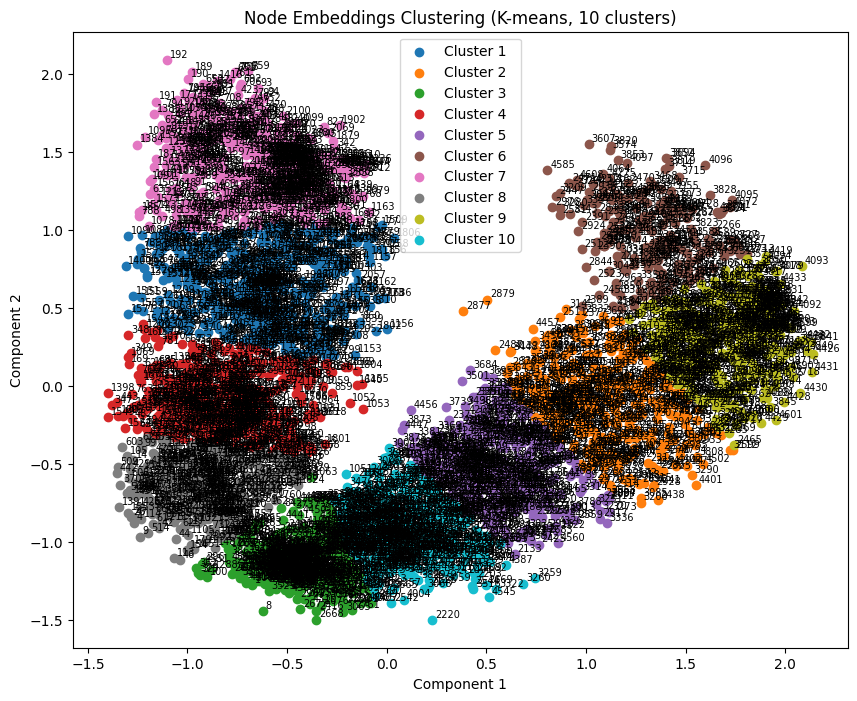

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [28]:
num_vars, clauses = read_dimacs_cnf(filename)
G = adding_to_graph(clauses)
print(num_vars)
node_embeddings_model = generate_node_embeddings(G)
print("Before visualization")
# visualize_node_embeddings(node_embeddings_model)
visualize_cluster_node_embeddings(node_embeddings_model, G, num_clusters=10)
# visualize_interactive(node_embeddings_model, G, num_clusters=10)

In [31]:
visualize_interactive(node_embeddings_model, G, num_clusters=10)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

